# Severstel : Steel Defect Detection

In [89]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

from tqdm import tqdm

In [70]:
!ls data

sample_submission.csv  test_images.zip	train_images
test_images	       train.csv	train_images.zip


In [55]:
train_df = pd.read_csv("data/train.csv")
sample_df = pd.read_csv("data/sample_submission.csv")

In [29]:
train_df.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [30]:
sample_df.head()

ImageId_ClassId EncodedPixels
0  004f40c73.jpg_1           1 1
1  004f40c73.jpg_2           1 1
2  004f40c73.jpg_3           1 1
3  004f40c73.jpg_4           1 1
4  006f39c41.jpg_1           1 1

### Check the number of each class

In [36]:
class_dict = defaultdict(int) 
kind_class_dict = defaultdict(int) 

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split('_')[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
    
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
        
    kind_class_dict[sum(labels.isna().values == False)] += 1
    
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [37]:
print(f'The number of images with no defects: {no_defects_num}')
print(f'The number of images with defects: {defects_num}')

The number of images with no defects: 5902
The number of images with defects: 6666


defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

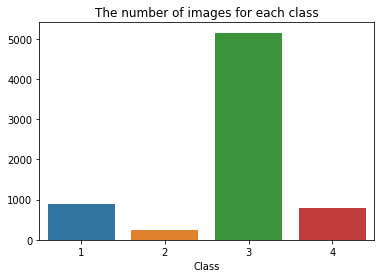

In [38]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("The number of images for each class")
ax.set_xlabel("Class")
class_dict

- There are similar number of classes with and without defects
- Class is imbalanced

#### How many classes do each image have?

defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

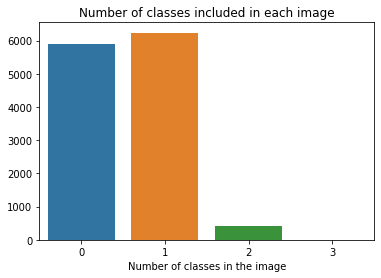

In [39]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image")
ax.set_xlabel("Number of classes in the image")
kind_class_dict

- Almost all images have no defect or one kind of defect 

### Check image data

#### Image Size

In [57]:
train_size_dict = defaultdict(int)
train_path = Path('data/train_images/')

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1 

In [58]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [59]:
test_size_dict = defaultdict(int)
test_path = Path('data/test_images/')

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1 

In [60]:
test_size_dict

defaultdict(int, {(1600, 256): 1801})

- All images have the same shape, (1600, 256)

## Visualization with masks

In [71]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

In [72]:
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

In [73]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

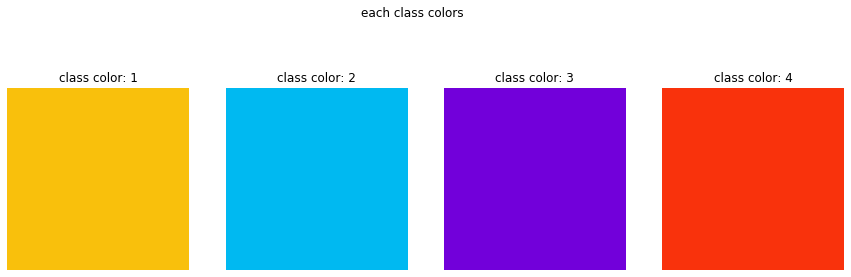

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [78]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

### Image with no defect

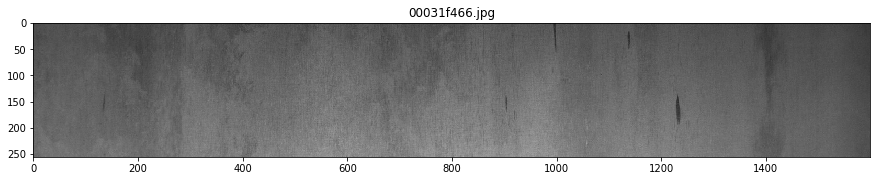

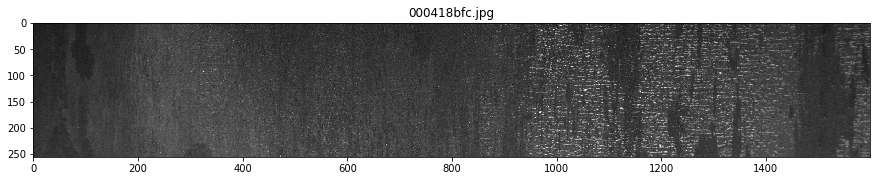

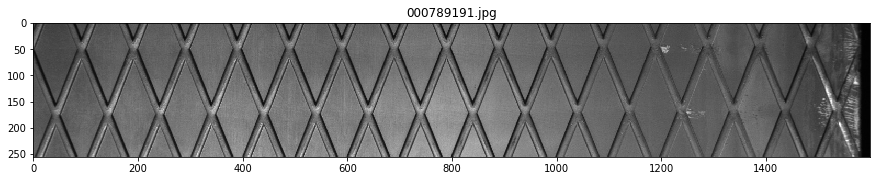

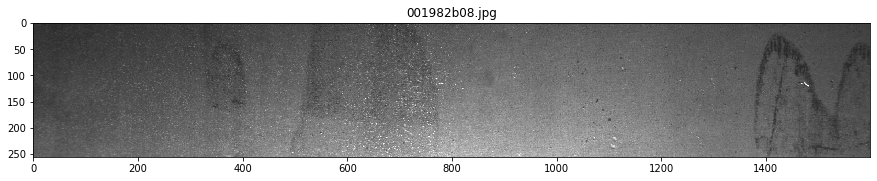

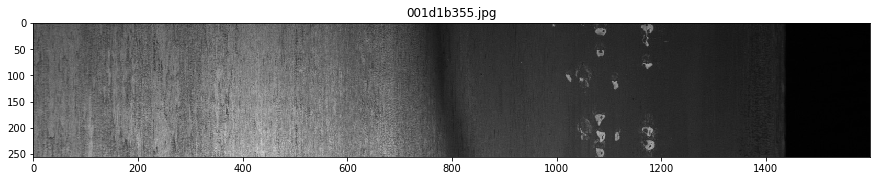

In [79]:
for idx in idx_no_defect[:5]:
    show_mask_image(idx)

### Image with defect(label: 1)

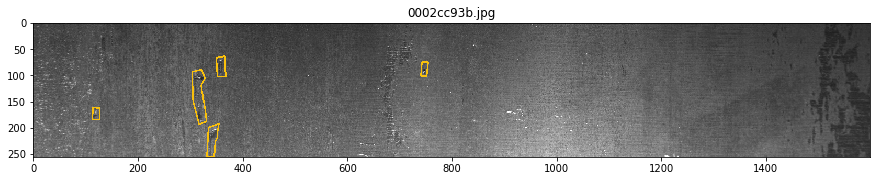

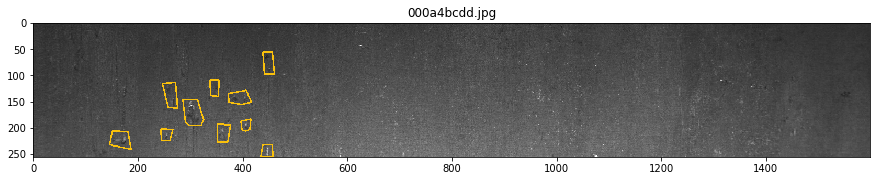

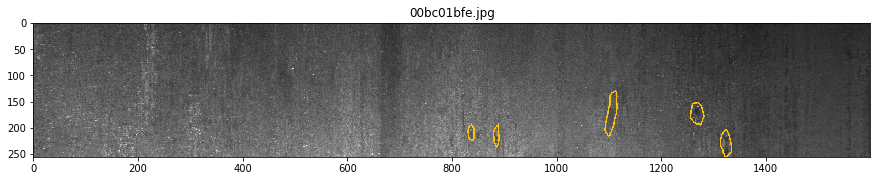

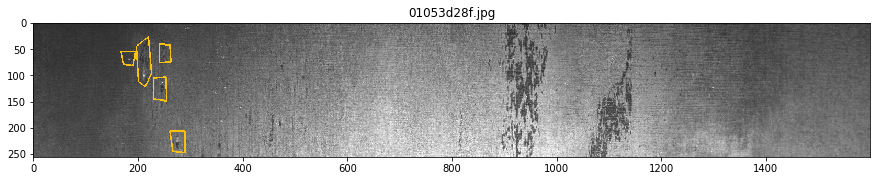

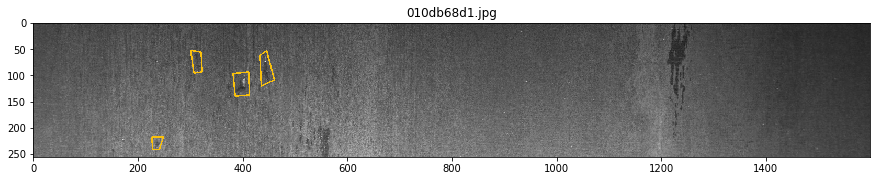

In [80]:
for idx in idx_class_1[:5]:
    show_mask_image(idx)

### Images with defect(label: 2)

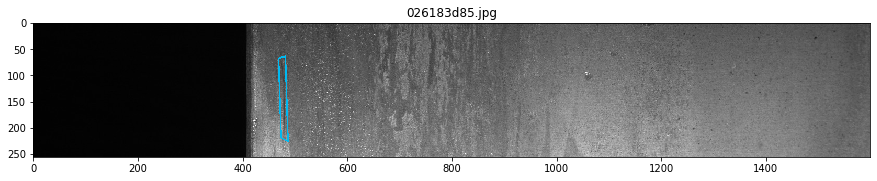

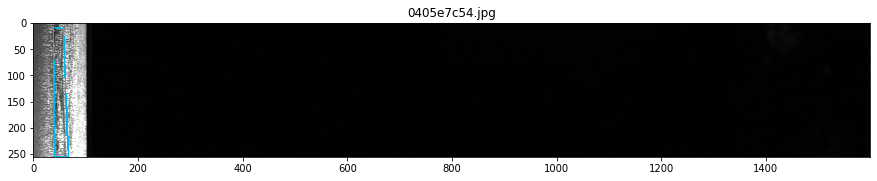

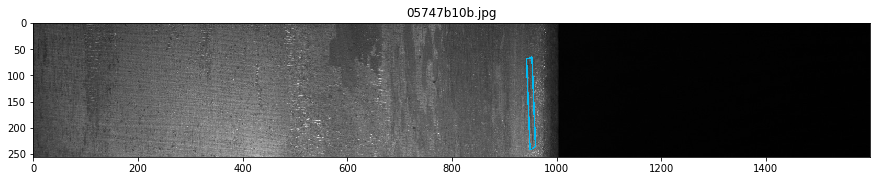

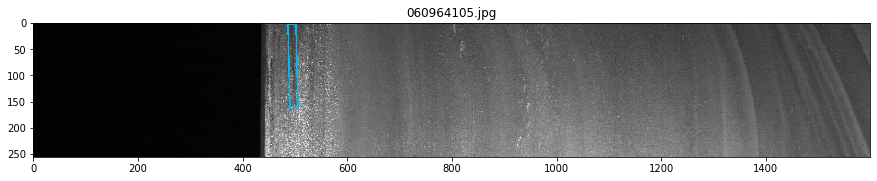

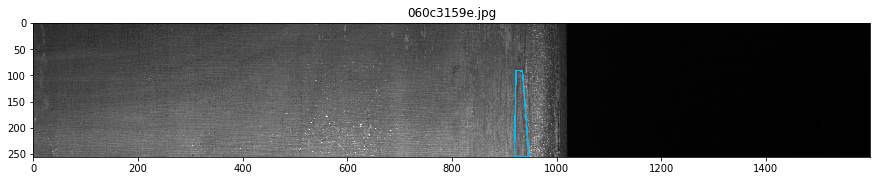

In [81]:
for idx in idx_class_2[:5]:
    show_mask_image(idx)

### Images with defect(label: 3)

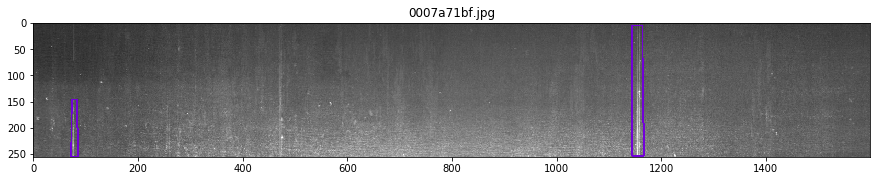

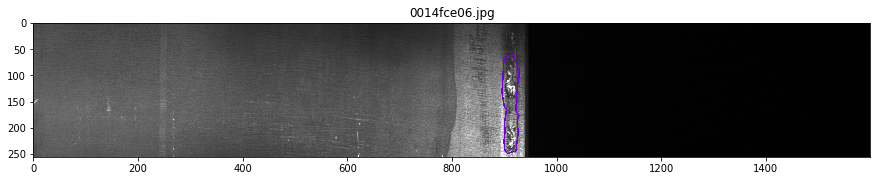

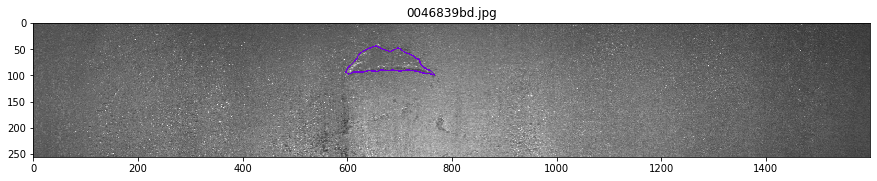

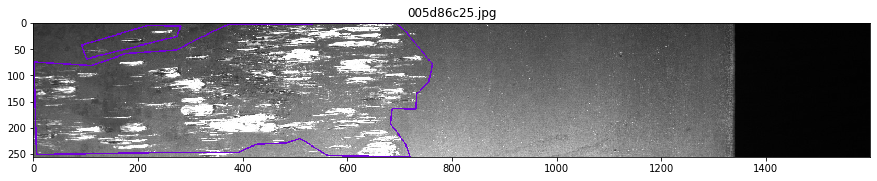

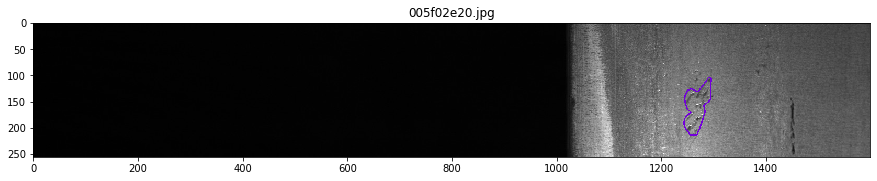

In [82]:
for idx in idx_class_3[:5]:
    show_mask_image(idx)

### Images with defect(label: 4)

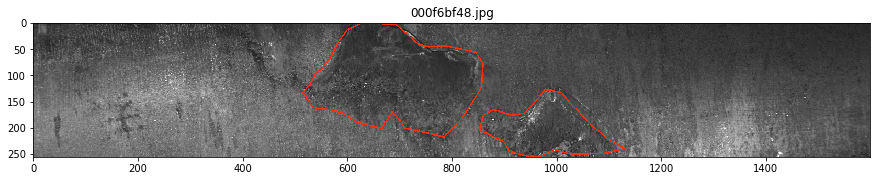

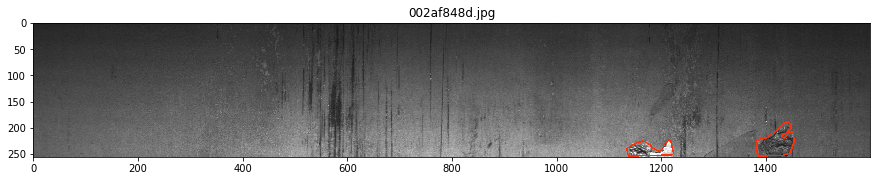

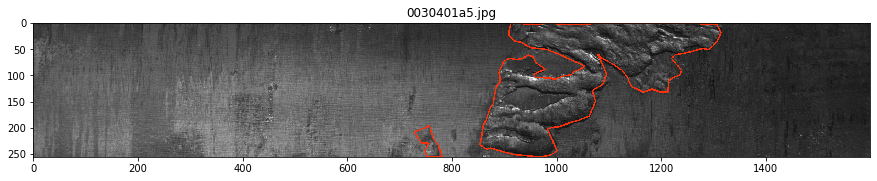

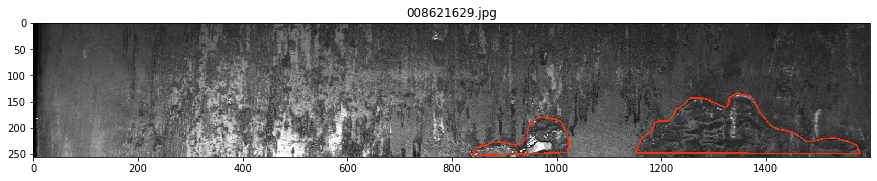

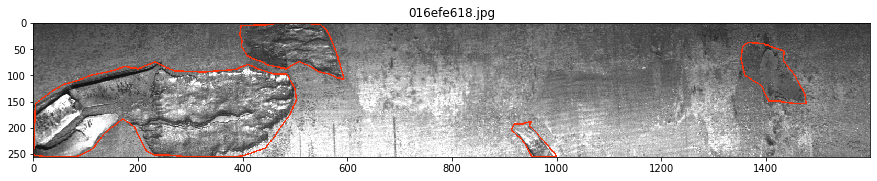

In [83]:
for idx in idx_class_4[:5]:
    show_mask_image(idx)

### Images with defect(contain multi label)

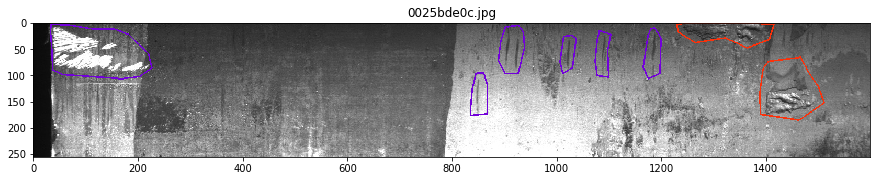

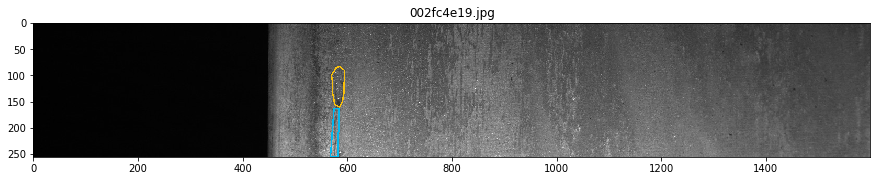

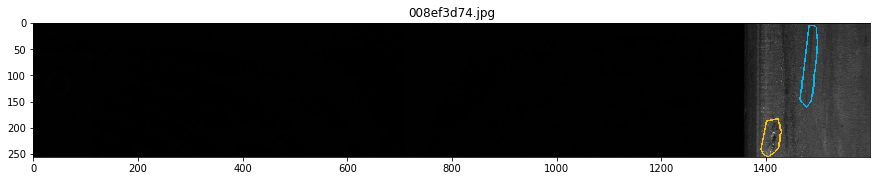

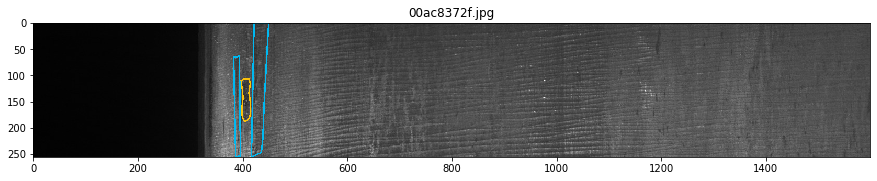

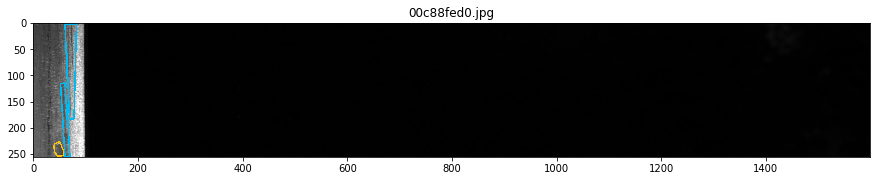

In [85]:
for idx in idx_class_multi[:5]:
    show_mask_image(idx)

### Images with defect(contain 3 type label)

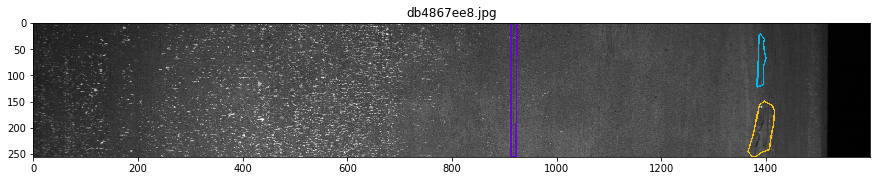

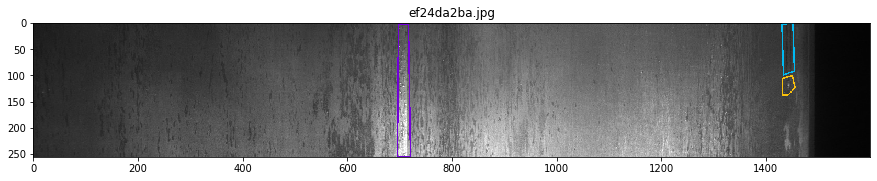

In [87]:
for idx in idx_class_triple:
    show_mask_image(idx)

#### Checking if there is any pixel with multi label

In [92]:
for col in tqdm(range(0, len(train_df), 4)):
    name, mask = name_and_mask(col)
    if (mask.sum(axis=2) >= 2).any():
        show_mask_image(idx)



  0%|          | 0/12568 [00:00<?, ?it/s]

  0%|          | 6/12568 [00:00<04:00, 52.33it/s]

  0%|          | 12/12568 [00:00<03:57, 52.98it/s]

  0%|          | 18/12568 [00:00<03:57, 52.87it/s]

  0%|          | 24/12568 [00:00<03:55, 53.22it/s]

  0%|          | 30/12568 [00:00<03:53, 53.76it/s]

  0%|          | 35/12568 [00:00<03:58, 52.52it/s]

  0%|          | 41/12568 [00:00<03:58, 52.41it/s]

  0%|          | 47/12568 [00:00<03:55, 53.18it/s]

  0%|          | 53/12568 [00:00<03:53, 53.51it/s]

  0%|          | 59/12568 [00:01<03:47, 55.10it/s]

  1%|          | 65/12568 [00:01<03:55, 53.02it/s]

  1%|          | 71/12568 [00:01<03:57, 52.68it/s]

  1%|          | 77/12568 [00:01<04:01, 51.71it/s]

  1%|          | 83/12568 [00:01<04:01, 51.68it/s]

  1%|          | 89/12568 [00:01<04:03, 51.25it/s]

  1%|          | 95/12568 [00:01<04:02, 51.33it/s]

  1%|          | 101/12568 [00:01<04:00, 51.79it/s]

  1%|          | 107/12568 [00:02<03:58, 52.36it/s]

  1%|          | 1

  7%|▋         | 829/12568 [00:15<03:39, 53.42it/s]

  7%|▋         | 835/12568 [00:15<03:34, 54.63it/s]

  7%|▋         | 841/12568 [00:15<03:34, 54.71it/s]

  7%|▋         | 847/12568 [00:16<03:33, 54.97it/s]

  7%|▋         | 853/12568 [00:16<03:37, 53.96it/s]

  7%|▋         | 859/12568 [00:16<03:34, 54.70it/s]

  7%|▋         | 865/12568 [00:16<03:30, 55.68it/s]

  7%|▋         | 871/12568 [00:16<03:31, 55.35it/s]

  7%|▋         | 877/12568 [00:16<03:34, 54.39it/s]

  7%|▋         | 883/12568 [00:16<03:33, 54.77it/s]

  7%|▋         | 889/12568 [00:16<03:34, 54.37it/s]

  7%|▋         | 895/12568 [00:16<03:36, 53.91it/s]

  7%|▋         | 901/12568 [00:17<03:37, 53.70it/s]

  7%|▋         | 907/12568 [00:17<03:38, 53.34it/s]

  7%|▋         | 913/12568 [00:17<03:38, 53.26it/s]

  7%|▋         | 919/12568 [00:17<03:39, 52.96it/s]

  7%|▋         | 925/12568 [00:17<03:37, 53.47it/s]

  7%|▋         | 931/12568 [00:17<03:38, 53.34it/s]

  7%|▋         | 937/12568 [00:17<03:35, 53.88

 13%|█▎        | 1651/12568 [00:31<03:25, 53.02it/s]

 13%|█▎        | 1657/12568 [00:31<03:21, 54.11it/s]

 13%|█▎        | 1663/12568 [00:31<03:21, 54.05it/s]

 13%|█▎        | 1669/12568 [00:31<03:24, 53.28it/s]

 13%|█▎        | 1675/12568 [00:31<03:18, 54.77it/s]

 13%|█▎        | 1681/12568 [00:31<03:19, 54.69it/s]

 13%|█▎        | 1687/12568 [00:31<03:20, 54.37it/s]

 13%|█▎        | 1693/12568 [00:31<03:15, 55.75it/s]

 14%|█▎        | 1699/12568 [00:31<03:16, 55.18it/s]

 14%|█▎        | 1705/12568 [00:32<03:22, 53.59it/s]

 14%|█▎        | 1711/12568 [00:32<03:21, 53.88it/s]

 14%|█▎        | 1717/12568 [00:32<03:19, 54.30it/s]

 14%|█▎        | 1723/12568 [00:32<03:16, 55.09it/s]

 14%|█▍        | 1729/12568 [00:32<03:15, 55.52it/s]

 14%|█▍        | 1735/12568 [00:32<03:15, 55.52it/s]

 14%|█▍        | 1741/12568 [00:32<03:14, 55.53it/s]

 14%|█▍        | 1747/12568 [00:32<03:19, 54.34it/s]

 14%|█▍        | 1753/12568 [00:32<03:18, 54.45it/s]

 14%|█▍        | 1759/12568 

 20%|█▉        | 2466/12568 [00:46<03:02, 55.38it/s]

 20%|█▉        | 2472/12568 [00:46<03:02, 55.37it/s]

 20%|█▉        | 2478/12568 [00:46<03:00, 56.03it/s]

 20%|█▉        | 2484/12568 [00:46<03:02, 55.22it/s]

 20%|█▉        | 2490/12568 [00:46<03:02, 55.18it/s]

 20%|█▉        | 2496/12568 [00:46<03:03, 54.79it/s]

 20%|█▉        | 2502/12568 [00:46<03:07, 53.81it/s]

 20%|█▉        | 2508/12568 [00:46<03:05, 54.32it/s]

 20%|██        | 2514/12568 [00:47<03:06, 54.05it/s]

 20%|██        | 2520/12568 [00:47<03:04, 54.44it/s]

 20%|██        | 2526/12568 [00:47<03:02, 54.95it/s]

 20%|██        | 2532/12568 [00:47<03:04, 54.43it/s]

 20%|██        | 2538/12568 [00:47<03:02, 55.10it/s]

 20%|██        | 2544/12568 [00:47<03:00, 55.69it/s]

 20%|██        | 2550/12568 [00:47<02:58, 56.00it/s]

 20%|██        | 2556/12568 [00:47<03:02, 54.97it/s]

 20%|██        | 2562/12568 [00:47<03:03, 54.61it/s]

 20%|██        | 2568/12568 [00:48<03:02, 54.81it/s]

 20%|██        | 2574/12568 

 26%|██▌       | 3282/12568 [01:01<02:49, 54.64it/s]

 26%|██▌       | 3288/12568 [01:01<02:49, 54.80it/s]

 26%|██▌       | 3294/12568 [01:01<02:50, 54.39it/s]

 26%|██▋       | 3300/12568 [01:01<02:51, 54.11it/s]

 26%|██▋       | 3306/12568 [01:01<02:50, 54.40it/s]

 26%|██▋       | 3312/12568 [01:01<02:48, 54.86it/s]

 26%|██▋       | 3318/12568 [01:02<02:46, 55.50it/s]

 26%|██▋       | 3324/12568 [01:02<02:47, 55.25it/s]

 26%|██▋       | 3330/12568 [01:02<02:49, 54.47it/s]

 27%|██▋       | 3336/12568 [01:02<02:49, 54.60it/s]

 27%|██▋       | 3342/12568 [01:02<02:45, 55.79it/s]

 27%|██▋       | 3348/12568 [01:02<02:44, 56.16it/s]

 27%|██▋       | 3354/12568 [01:02<02:44, 55.85it/s]

 27%|██▋       | 3360/12568 [01:02<02:46, 55.32it/s]

 27%|██▋       | 3366/12568 [01:02<02:45, 55.45it/s]

 27%|██▋       | 3372/12568 [01:02<02:44, 55.76it/s]

 27%|██▋       | 3378/12568 [01:03<02:45, 55.43it/s]

 27%|██▋       | 3384/12568 [01:03<02:46, 55.14it/s]

 27%|██▋       | 3390/12568 

 33%|███▎      | 4098/12568 [01:16<02:36, 54.22it/s]

 33%|███▎      | 4104/12568 [01:16<02:33, 55.10it/s]

 33%|███▎      | 4110/12568 [01:16<02:34, 54.63it/s]

 33%|███▎      | 4116/12568 [01:16<02:33, 55.14it/s]

 33%|███▎      | 4122/12568 [01:16<02:32, 55.38it/s]

 33%|███▎      | 4128/12568 [01:16<02:29, 56.58it/s]

 33%|███▎      | 4135/12568 [01:16<02:25, 58.02it/s]

 33%|███▎      | 4141/12568 [01:17<02:26, 57.49it/s]

 33%|███▎      | 4147/12568 [01:17<02:26, 57.52it/s]

 33%|███▎      | 4153/12568 [01:17<02:27, 56.89it/s]

 33%|███▎      | 4159/12568 [01:17<02:27, 56.97it/s]

 33%|███▎      | 4165/12568 [01:17<02:27, 56.95it/s]

 33%|███▎      | 4171/12568 [01:17<02:29, 56.17it/s]

 33%|███▎      | 4177/12568 [01:17<02:29, 56.11it/s]

 33%|███▎      | 4183/12568 [01:17<02:30, 55.53it/s]

 33%|███▎      | 4189/12568 [01:17<02:29, 56.11it/s]

 33%|███▎      | 4195/12568 [01:17<02:30, 55.60it/s]

 33%|███▎      | 4201/12568 [01:18<02:31, 55.27it/s]

 33%|███▎      | 4207/12568 

 39%|███▉      | 4915/12568 [01:31<02:22, 53.66it/s]

 39%|███▉      | 4921/12568 [01:31<02:21, 54.10it/s]

 39%|███▉      | 4927/12568 [01:31<02:21, 53.98it/s]

 39%|███▉      | 4933/12568 [01:31<02:20, 54.46it/s]

 39%|███▉      | 4939/12568 [01:31<02:19, 54.75it/s]

 39%|███▉      | 4945/12568 [01:31<02:21, 54.05it/s]

 39%|███▉      | 4951/12568 [01:32<02:19, 54.57it/s]

 39%|███▉      | 4957/12568 [01:32<02:18, 54.85it/s]

 39%|███▉      | 4963/12568 [01:32<02:18, 54.96it/s]

 40%|███▉      | 4969/12568 [01:32<02:24, 52.64it/s]

 40%|███▉      | 4975/12568 [01:32<02:19, 54.24it/s]

 40%|███▉      | 4981/12568 [01:32<02:18, 54.65it/s]

 40%|███▉      | 4987/12568 [01:32<02:18, 54.54it/s]

 40%|███▉      | 4993/12568 [01:32<02:20, 54.09it/s]

 40%|███▉      | 4999/12568 [01:32<02:17, 54.93it/s]

 40%|███▉      | 5005/12568 [01:33<02:16, 55.36it/s]

 40%|███▉      | 5011/12568 [01:33<02:15, 55.78it/s]

 40%|███▉      | 5017/12568 [01:33<02:14, 56.12it/s]

 40%|███▉      | 5023/12568 

 46%|████▌     | 5731/12568 [01:46<02:02, 55.84it/s]

 46%|████▌     | 5737/12568 [01:46<02:03, 55.09it/s]

 46%|████▌     | 5743/12568 [01:46<02:02, 55.74it/s]

 46%|████▌     | 5749/12568 [01:46<02:02, 55.74it/s]

 46%|████▌     | 5755/12568 [01:46<02:03, 55.25it/s]

 46%|████▌     | 5761/12568 [01:46<02:02, 55.47it/s]

 46%|████▌     | 5767/12568 [01:46<02:03, 54.90it/s]

 46%|████▌     | 5773/12568 [01:47<02:02, 55.45it/s]

 46%|████▌     | 5779/12568 [01:47<02:01, 55.98it/s]

 46%|████▌     | 5785/12568 [01:47<02:00, 56.49it/s]

 46%|████▌     | 5791/12568 [01:47<02:00, 56.06it/s]

 46%|████▌     | 5797/12568 [01:47<02:01, 55.65it/s]

 46%|████▌     | 5803/12568 [01:47<02:01, 55.88it/s]

 46%|████▌     | 5809/12568 [01:47<02:00, 55.86it/s]

 46%|████▋     | 5815/12568 [01:47<02:01, 55.43it/s]

 46%|████▋     | 5821/12568 [01:47<02:02, 55.21it/s]

 46%|████▋     | 5827/12568 [01:47<02:02, 55.10it/s]

 46%|████▋     | 5833/12568 [01:48<02:05, 53.82it/s]

 46%|████▋     | 5839/12568 

 52%|█████▏    | 6547/12568 [02:01<01:49, 54.94it/s]

 52%|█████▏    | 6553/12568 [02:01<01:51, 53.88it/s]

 52%|█████▏    | 6559/12568 [02:01<01:51, 53.85it/s]

 52%|█████▏    | 6565/12568 [02:01<01:51, 53.96it/s]

 52%|█████▏    | 6571/12568 [02:01<01:50, 54.45it/s]

 52%|█████▏    | 6577/12568 [02:01<01:49, 54.57it/s]

 52%|█████▏    | 6583/12568 [02:01<01:50, 54.25it/s]

 52%|█████▏    | 6589/12568 [02:01<01:48, 55.24it/s]

 52%|█████▏    | 6595/12568 [02:02<01:47, 55.60it/s]

 53%|█████▎    | 6601/12568 [02:02<01:48, 55.17it/s]

 53%|█████▎    | 6607/12568 [02:02<01:47, 55.43it/s]

 53%|█████▎    | 6613/12568 [02:02<01:47, 55.15it/s]

 53%|█████▎    | 6619/12568 [02:02<01:47, 55.45it/s]

 53%|█████▎    | 6625/12568 [02:02<01:47, 55.36it/s]

 53%|█████▎    | 6631/12568 [02:02<01:47, 55.41it/s]

 53%|█████▎    | 6637/12568 [02:02<01:45, 56.43it/s]

 53%|█████▎    | 6643/12568 [02:02<01:46, 55.84it/s]

 53%|█████▎    | 6649/12568 [02:03<01:47, 55.12it/s]

 53%|█████▎    | 6655/12568 

 59%|█████▊    | 7364/12568 [02:16<01:35, 54.33it/s]

 59%|█████▊    | 7370/12568 [02:16<01:35, 54.65it/s]

 59%|█████▊    | 7376/12568 [02:16<01:34, 54.83it/s]

 59%|█████▊    | 7382/12568 [02:16<01:33, 55.31it/s]

 59%|█████▉    | 7388/12568 [02:16<01:34, 54.76it/s]

 59%|█████▉    | 7394/12568 [02:16<01:33, 55.16it/s]

 59%|█████▉    | 7400/12568 [02:16<01:32, 55.83it/s]

 59%|█████▉    | 7406/12568 [02:16<01:32, 56.08it/s]

 59%|█████▉    | 7412/12568 [02:16<01:31, 56.06it/s]

 59%|█████▉    | 7418/12568 [02:17<01:30, 56.98it/s]

 59%|█████▉    | 7424/12568 [02:17<01:28, 57.82it/s]

 59%|█████▉    | 7430/12568 [02:17<01:30, 57.06it/s]

 59%|█████▉    | 7436/12568 [02:17<01:31, 55.97it/s]

 59%|█████▉    | 7442/12568 [02:17<01:32, 55.58it/s]

 59%|█████▉    | 7448/12568 [02:17<01:31, 56.09it/s]

 59%|█████▉    | 7454/12568 [02:17<01:30, 56.42it/s]

 59%|█████▉    | 7460/12568 [02:17<01:32, 55.03it/s]

 59%|█████▉    | 7466/12568 [02:17<01:32, 54.98it/s]

 59%|█████▉    | 7472/12568 

 65%|██████▌   | 8182/12568 [02:30<01:22, 53.37it/s]

 65%|██████▌   | 8188/12568 [02:31<01:21, 53.58it/s]

 65%|██████▌   | 8194/12568 [02:31<01:20, 54.16it/s]

 65%|██████▌   | 8200/12568 [02:31<01:19, 54.81it/s]

 65%|██████▌   | 8206/12568 [02:31<01:20, 54.45it/s]

 65%|██████▌   | 8212/12568 [02:31<01:19, 54.51it/s]

 65%|██████▌   | 8218/12568 [02:31<01:18, 55.29it/s]

 65%|██████▌   | 8224/12568 [02:31<01:19, 54.86it/s]

 65%|██████▌   | 8230/12568 [02:31<01:17, 55.89it/s]

 66%|██████▌   | 8236/12568 [02:31<01:16, 56.77it/s]

 66%|██████▌   | 8242/12568 [02:31<01:17, 55.90it/s]

 66%|██████▌   | 8248/12568 [02:32<01:16, 56.58it/s]

 66%|██████▌   | 8254/12568 [02:32<01:16, 56.65it/s]

 66%|██████▌   | 8260/12568 [02:32<01:15, 57.38it/s]

 66%|██████▌   | 8266/12568 [02:32<01:17, 55.84it/s]

 66%|██████▌   | 8272/12568 [02:32<01:16, 56.17it/s]

 66%|██████▌   | 8278/12568 [02:32<01:16, 55.99it/s]

 66%|██████▌   | 8284/12568 [02:32<01:17, 55.43it/s]

 66%|██████▌   | 8290/12568 

 72%|███████▏  | 8998/12568 [02:45<01:06, 54.07it/s]

 72%|███████▏  | 9004/12568 [02:46<01:07, 52.55it/s]

 72%|███████▏  | 9010/12568 [02:46<01:07, 52.45it/s]

 72%|███████▏  | 9016/12568 [02:46<01:06, 53.18it/s]

 72%|███████▏  | 9022/12568 [02:46<01:06, 53.34it/s]

 72%|███████▏  | 9028/12568 [02:46<01:05, 53.64it/s]

 72%|███████▏  | 9034/12568 [02:46<01:05, 54.36it/s]

 72%|███████▏  | 9040/12568 [02:46<01:04, 54.64it/s]

 72%|███████▏  | 9046/12568 [02:46<01:04, 54.21it/s]

 72%|███████▏  | 9052/12568 [02:46<01:04, 54.55it/s]

 72%|███████▏  | 9058/12568 [02:47<01:04, 54.66it/s]

 72%|███████▏  | 9064/12568 [02:47<01:03, 55.35it/s]

 72%|███████▏  | 9070/12568 [02:47<01:03, 55.27it/s]

 72%|███████▏  | 9076/12568 [02:47<01:03, 54.86it/s]

 72%|███████▏  | 9082/12568 [02:47<01:03, 54.88it/s]

 72%|███████▏  | 9088/12568 [02:47<01:02, 55.38it/s]

 72%|███████▏  | 9094/12568 [02:47<01:02, 55.83it/s]

 72%|███████▏  | 9100/12568 [02:47<01:02, 55.45it/s]

 72%|███████▏  | 9106/12568 

 78%|███████▊  | 9814/12568 [03:00<00:50, 54.63it/s]

 78%|███████▊  | 9820/12568 [03:01<00:49, 55.70it/s]

 78%|███████▊  | 9826/12568 [03:01<00:49, 55.43it/s]

 78%|███████▊  | 9832/12568 [03:01<00:49, 55.11it/s]

 78%|███████▊  | 9838/12568 [03:01<00:50, 53.70it/s]

 78%|███████▊  | 9844/12568 [03:01<00:50, 54.14it/s]

 78%|███████▊  | 9850/12568 [03:01<00:49, 54.62it/s]

 78%|███████▊  | 9856/12568 [03:01<00:49, 54.81it/s]

 78%|███████▊  | 9862/12568 [03:01<00:49, 54.18it/s]

 79%|███████▊  | 9868/12568 [03:01<00:49, 54.46it/s]

 79%|███████▊  | 9874/12568 [03:02<00:48, 55.15it/s]

 79%|███████▊  | 9880/12568 [03:02<00:49, 54.70it/s]

 79%|███████▊  | 9886/12568 [03:02<00:49, 54.44it/s]

 79%|███████▊  | 9892/12568 [03:02<00:49, 54.31it/s]

 79%|███████▉  | 9898/12568 [03:02<00:49, 53.50it/s]

 79%|███████▉  | 9904/12568 [03:02<00:49, 53.71it/s]

 79%|███████▉  | 9910/12568 [03:02<00:48, 54.67it/s]

 79%|███████▉  | 9916/12568 [03:02<00:47, 55.50it/s]

 79%|███████▉  | 9922/12568 

 84%|████████▍ | 10618/12568 [03:15<00:35, 54.53it/s]

 85%|████████▍ | 10624/12568 [03:15<00:36, 52.64it/s]

 85%|████████▍ | 10630/12568 [03:15<00:37, 52.17it/s]

 85%|████████▍ | 10636/12568 [03:16<00:36, 52.95it/s]

 85%|████████▍ | 10642/12568 [03:16<00:35, 54.46it/s]

 85%|████████▍ | 10648/12568 [03:16<00:34, 55.51it/s]

 85%|████████▍ | 10654/12568 [03:16<00:34, 55.26it/s]

 85%|████████▍ | 10660/12568 [03:16<00:34, 54.79it/s]

 85%|████████▍ | 10666/12568 [03:16<00:34, 55.24it/s]

 85%|████████▍ | 10672/12568 [03:16<00:34, 55.43it/s]

 85%|████████▍ | 10678/12568 [03:16<00:33, 55.59it/s]

 85%|████████▌ | 10684/12568 [03:16<00:33, 55.59it/s]

 85%|████████▌ | 10690/12568 [03:16<00:34, 55.17it/s]

 85%|████████▌ | 10696/12568 [03:17<00:33, 56.43it/s]

 85%|████████▌ | 10702/12568 [03:17<00:32, 56.56it/s]

 85%|████████▌ | 10708/12568 [03:17<00:32, 56.64it/s]

 85%|████████▌ | 10714/12568 [03:17<00:32, 57.03it/s]

 85%|████████▌ | 10720/12568 [03:17<00:33, 55.84it/s]

 85%|█████

 91%|█████████ | 11422/12568 [03:30<00:20, 54.75it/s]

 91%|█████████ | 11428/12568 [03:30<00:20, 55.05it/s]

 91%|█████████ | 11434/12568 [03:30<00:20, 54.25it/s]

 91%|█████████ | 11440/12568 [03:30<00:20, 54.89it/s]

 91%|█████████ | 11446/12568 [03:30<00:20, 55.47it/s]

 91%|█████████ | 11452/12568 [03:31<00:19, 55.87it/s]

 91%|█████████ | 11458/12568 [03:31<00:19, 56.56it/s]

 91%|█████████ | 11464/12568 [03:31<00:19, 55.89it/s]

 91%|█████████▏| 11470/12568 [03:31<00:19, 55.60it/s]

 91%|█████████▏| 11476/12568 [03:31<00:19, 55.73it/s]

 91%|█████████▏| 11482/12568 [03:31<00:19, 55.66it/s]

 91%|█████████▏| 11488/12568 [03:31<00:19, 55.68it/s]

 91%|█████████▏| 11494/12568 [03:31<00:19, 55.47it/s]

 92%|█████████▏| 11500/12568 [03:31<00:19, 55.84it/s]

 92%|█████████▏| 11506/12568 [03:31<00:19, 55.73it/s]

 92%|█████████▏| 11512/12568 [03:32<00:19, 55.35it/s]

 92%|█████████▏| 11518/12568 [03:32<00:18, 55.82it/s]

 92%|█████████▏| 11524/12568 [03:32<00:18, 55.92it/s]

 92%|█████

 97%|█████████▋| 12227/12568 [03:45<00:06, 55.33it/s]

 97%|█████████▋| 12233/12568 [03:45<00:06, 54.81it/s]

 97%|█████████▋| 12239/12568 [03:45<00:06, 54.14it/s]

 97%|█████████▋| 12245/12568 [03:45<00:05, 55.23it/s]

 97%|█████████▋| 12251/12568 [03:45<00:05, 55.70it/s]

 98%|█████████▊| 12257/12568 [03:45<00:05, 56.26it/s]

 98%|█████████▊| 12263/12568 [03:45<00:05, 55.73it/s]

 98%|█████████▊| 12269/12568 [03:45<00:05, 55.25it/s]

 98%|█████████▊| 12275/12568 [03:45<00:05, 56.10it/s]

 98%|█████████▊| 12281/12568 [03:46<00:05, 54.96it/s]

 98%|█████████▊| 12287/12568 [03:46<00:05, 55.56it/s]

 98%|█████████▊| 12293/12568 [03:46<00:04, 56.52it/s]

 98%|█████████▊| 12299/12568 [03:46<00:04, 55.58it/s]

 98%|█████████▊| 12305/12568 [03:46<00:04, 54.73it/s]

 98%|█████████▊| 12311/12568 [03:46<00:04, 55.35it/s]

 98%|█████████▊| 12317/12568 [03:46<00:04, 54.47it/s]

 98%|█████████▊| 12323/12568 [03:46<00:04, 54.11it/s]

 98%|█████████▊| 12329/12568 [03:46<00:04, 55.24it/s]

 98%|█████

- All pixels have one or less labels